In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.model_selection import GridSearchCV
import joblib
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from optuna_dashboard import run_server
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer


In [28]:
pub = pd.read_csv('data/public_data.csv')
submit_template = pd.read_csv('data/minta_beadando_rand.csv')

In [29]:
def train_test_split_function(x):
    if x == 4:
        return "submit"
    elif x == 3:
        return "test"
    else:
        return "train"

In [30]:
pub['train_test_validation'] = pub['day_in_period'].apply(train_test_split_function)


In [31]:
pub['ke_hupx_ratio'] = pub['ke'] / pub['hupx']
for lag in range(1, 5):
    pub[f'ke_lag_{lag}'] = pub.groupby('periodID')['ke'].shift(lag)

In [32]:
input_variables = [
    'hour', 'minute', 'holyday', 'weekday', 'ke', 'hupx', 'afrr_fel', 'afrr_le',
    'mfrr_fel', 'mfrr_le', 'afrr', 'solar_becsult_dayahead',
    'rendszerterheles_terv', 'ke_hupx_ratio', 'ke_lag_1', 'ke_lag_2', 'ke_lag_3', 'ke_lag_4'
]


In [33]:
train_df = pub[pub['train_test_validation'] == 'train'].dropna()
test_df = pub[pub['train_test_validation'] == 'test'].dropna()
submit_df = pub[pub['train_test_validation'] == 'submit']

In [34]:
X_train = train_df[input_variables]
y_train = train_df['target_flag']

X_test = test_df[input_variables]
y_test = test_df['target_flag']

In [35]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [36]:
def objective(trial, X_train_param, y_train_param, X_test_param, y_test_param):
    rf_model = RandomForestClassifier(
        n_estimators=trial.suggest_int('rf_n_estimators', 10, 1000),
        max_depth=trial.suggest_int('rf_max_depth', 1, 10),
        min_samples_split=trial.suggest_int('rf_min_samples_split', 2, 30),
        random_state=42
    )
    gb_model = GradientBoostingClassifier(
        n_estimators=trial.suggest_int('gb_n_estimators', 10, 1000),
        max_depth=trial.suggest_int('gb_max_depth', 1, 10),
        min_samples_split=trial.suggest_int('gb_min_samples_split', 2, 30),
        learning_rate=trial.suggest_float('gb_learning_rate', 0.01, 0.1, log=True),
        random_state=42
    )
    rf_model.fit(X_train_param, y_train_param)
    rf_y_pred = rf_model.predict_proba(X_test_param)[:, 1]
    gb_model.fit(X_train_param, y_train_param)
    gb_y_pred = gb_model.predict_proba(X_test_param)[:, 1]
    return roc_auc_score(y_test_param, (rf_y_pred + gb_y_pred) / 2)

In [24]:

db_storage = "sqlite:///db.sqlite3"
current_datetime = datetime.datetime.now()
study_name = f"ensemble{current_datetime.strftime('%Y-%m-%d_%H-%M-%S')}"
study = optuna.create_study(
    direction="minimize",
    storage=db_storage,
    study_name=study_name,
)
study.optimize(lambda trial: objective(trial, X_train_smote, y_train_smote, X_test, y_test), n_trials=5, n_jobs=-1)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2024-12-11 01:10:59,737] A new study created in RDB with name: ensemble2024-12-11_01-10-59
[I 2024-12-11 01:13:35,568] Trial 1 finished with value: 0.9924804970873718 and parameters: {'rf_n_estimators': 920, 'rf_max_depth': 2, 'rf_min_samples_split': 2, 'gb_n_estimators': 529, 'gb_max_depth': 1, 'gb_min_samples_split': 7, 'gb_learning_rate': 0.05160059199483655}. Best is trial 1 with value: 0.9924804970873718.
[I 2024-12-11 01:21:06,940] Trial 2 finished with value: 0.998348094673554 and parameters: {'rf_n_estimators': 933, 'rf_max_depth': 9, 'rf_min_samples_split': 29, 'gb_n_estimators': 864, 'gb_max_depth': 3, 'gb_min_samples_split': 25, 'gb_learning_rate': 0.03722733273125995}. Best is trial 1 with value: 0.9924804970873718.
[I 2024-12-11 01:23:41,442] Trial 0 finished with value: 0.9956551926799678 and parameters: {'rf_n_estimators': 732, 'rf_max_depth': 5, 'rf_min_samples_split': 15, 'gb_n_estimators': 511, 'gb_max_depth': 9, 'gb_min_samples_split': 25, 'gb_learning_rate': 0.08

Accuracy: 0.9924804970873718
Best hyperparameters: {'rf_n_estimators': 920, 'rf_max_depth': 2, 'rf_min_samples_split': 2, 'gb_n_estimators': 529, 'gb_max_depth': 1, 'gb_min_samples_split': 7, 'gb_learning_rate': 0.05160059199483655}


In [25]:
print(study.best_params)

{'rf_n_estimators': 920, 'rf_max_depth': 2, 'rf_min_samples_split': 2, 'gb_n_estimators': 529, 'gb_max_depth': 1, 'gb_min_samples_split': 7, 'gb_learning_rate': 0.05160059199483655}


In [53]:
rf_model = RandomForestClassifier(max_depth=2, min_samples_leaf=50, min_samples_split=30, max_features=None,
                       n_estimators=33, random_state=42)
gb_model = GradientBoostingClassifier(learning_rate=0.0005, max_depth=2, min_samples_leaf=50,
                           min_samples_split=20, n_estimators=300,
                           random_state=42)

In [54]:
rf_model.fit(X_train_smote, y_train_smote)
gb_model.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(learning_rate=0.0005, max_depth=2,
                           min_samples_leaf=50, min_samples_split=20,
                           n_estimators=300, random_state=42)

In [55]:
# K-fold beállítása
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ROC AUC metrika beállítása
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Random Forest cross-validation
rf_scores = cross_val_score(rf_model, X_test, y_test, cv=kf, scoring=roc_auc_scorer)
print(f"Random Forest ROC AUC: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

# Gradient Boosting cross-validation
gb_scores = cross_val_score(gb_model, X_test, y_test, cv=kf, scoring=roc_auc_scorer)
print(f"Gradient Boosting ROC AUC: {gb_scores.mean():.4f} ± {gb_scores.std():.4f}")

c:\Users\ASUS\Documents\University\msc\2_felev\gepi_tanulas_esettanulmanyok\nagyhf\BME-TMIT-DataScience-Competition-2024\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Random Forest ROC AUC: 0.9808 ± 0.0033
Gradient Boosting ROC AUC: 0.9775 ± 0.0049


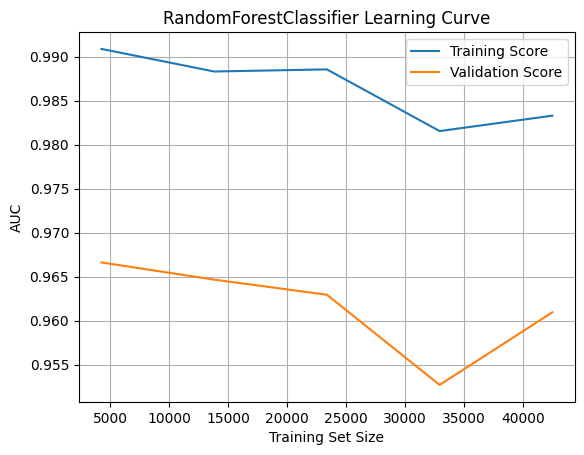

In [56]:
# Plotting to determine wether there is overfitting or underfitting
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('RandomForestClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [51]:
train_sizes, train_scores, test_scores = learning_curve(
    gb_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('GradientBoostingClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

KeyboardInterrupt: 

In [ ]:
run_server(db_storage)

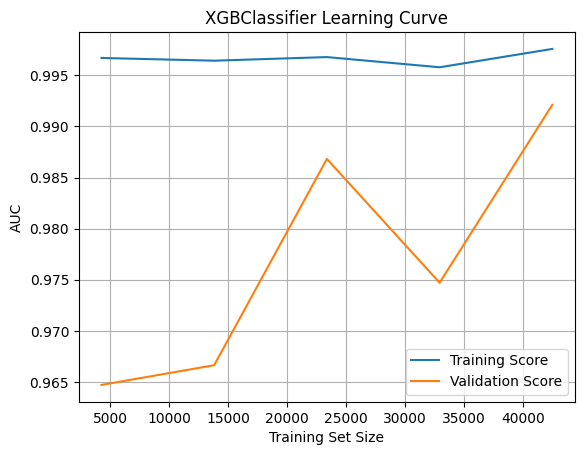

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('XGBClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

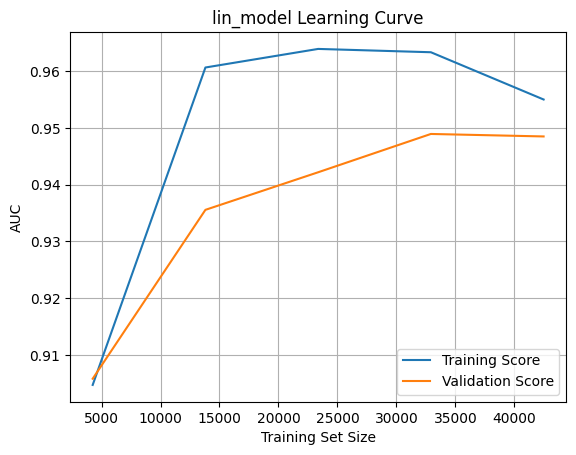

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    lin_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('lin_model Learning Curve')
plt.legend()
plt.grid()
plt.show()

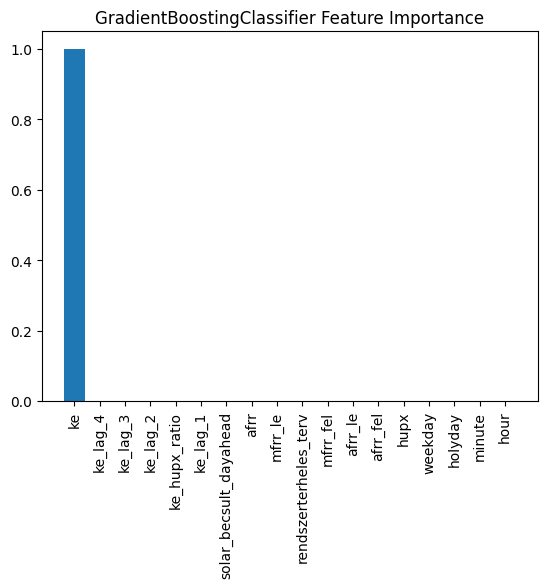

In [ ]:
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_variables[i] for i in indices], rotation=90)
plt.title('GradientBoostingClassifier Feature Importance')
plt.show()

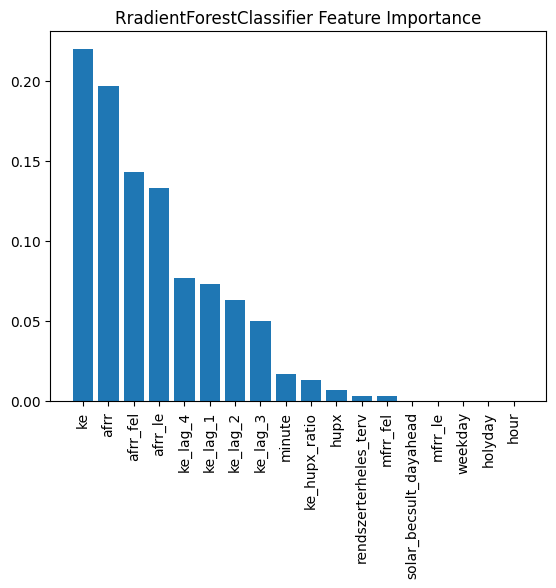

In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_variables[i] for i in indices], rotation=90)
plt.title('RradientForestClassifier Feature Importance')
plt.show()

In [156]:
rf_model.fit(X_train_smote, y_train_smote)
gb_model.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=300,
                           random_state=42)

In [157]:
rf_predictions = rf_model.predict_proba(X_test)[:, 1]
gb_predictions = gb_model.predict_proba(X_test)[:, 1]
# xgb_predictions = xgb_model.predict_proba(X_test)[:, 1]
# lin_predictions = lin_model.predict_proba(X_test)[:, 1]

rf_auc = roc_auc_score(y_test, rf_predictions)
gb_auc = roc_auc_score(y_test, gb_predictions)
# xgb_auc = roc_auc_score(y_test, xgb_predictions)
# lin_uac = roc_auc_score(y_test, lin_predictions)

print(f"Random Forest AUC: {rf_auc}")
print(f"Gradient Boosting AUC: {gb_auc}")
# print(f"XGB AUC: {xgb_auc}")
# print(f"Linear Regression AUC: {lin_uac}")

Random Forest AUC: 0.9851651013898505
Gradient Boosting AUC: 0.9942799278507176


In [159]:
ensemble_predictions = (gb_predictions + rf_predictions) / 2
ensemble_auc = roc_auc_score(y_test, ensemble_predictions)
print(f"Ensemble AUC: {ensemble_auc}")

Ensemble AUC: 0.9925005213156489


In [161]:
submit_df['prediction'] = ensemble_predictions
submit_df = submit_df[['rowID', 'prediction']]

In [162]:
current_time = datetime.datetime.now()
time_string = current_time.strftime("%Y%m%d_%H%M%S")
filename = f"prediction_datas/ensemble_{time_string}.csv"
submit_df.to_csv(filename, index=False)

print(f"Submission saved to {filename}")

Submission saved to prediction_datas/ensemble_20241210_223808.csv
